# Classical ML Models and Ensembles for G-K Phoneme Classification

**Goal**: Training classical ML models and their ensembles on data from `02.2_g-k_dl_data_preparation_with_context.ipynb`

**Models**:
- Gradient Boosting: XGBoost, LightGBM, CatBoost, sklearn GradientBoosting
- Tree-based: Random Forest, Extra Trees
- Linear: Logistic Regression, SVM
- Ensembles: Voting, Stacking, Blending

**Features**:
- Using all available CPU cores (M3 8 cores)
- Handling class imbalance
- Hyperparameter optimization
- Comparative analysis of all models


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
import joblib
import os
import time
import warnings
from datetime import datetime

# ML libraries
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score, 
    cross_val_predict, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    GradientBoostingClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# Gradient Boosting libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Project root
# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Data directory (with context v2 - includes VOT, burst features)
DATA_DIR = PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2'
FEATURES_DIR = DATA_DIR / 'features'
OUTPUT_DIR = DATA_DIR / 'ml_models'
RESULTS_DIR = DATA_DIR / 'ml_results'

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Multithreading configuration (M3 8 cores)
N_JOBS = os.cpu_count() or 8
RANDOM_STATE = 42

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Features directory: {FEATURES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"\nMultithreading: Using {N_JOBS} CPU cores")
print(f"Random state: {RANDOM_STATE}")


Project root: /Volumes/SSanDisk/SpeechRec-German
Data directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2
Features directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/features
Output directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models
Results directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_results

Multithreading: Using 8 CPU cores
Random state: 42


## 1. Data Loading


In [2]:
# Load feature columns
with open(DATA_DIR / 'feature_cols.json', 'r') as f:
    feature_cols = json.load(f)

# Load feature scaler
feature_scaler = joblib.load(DATA_DIR / 'feature_scaler.joblib')

# Load class weights
with open(DATA_DIR / 'class_weights.json', 'r') as f:
    class_weights_dict = json.load(f)

# Load split indices
with open(DATA_DIR / 'split_indices.json', 'r') as f:
    split_indices = json.load(f)

print(f"Loaded {len(feature_cols)} feature columns")
print(f"Class weights: {class_weights_dict}")
print(f"Train samples: {len(split_indices['train'])}")
print(f"Val samples: {len(split_indices['val'])}")
print(f"Test samples: {len(split_indices['test'])}")


Loaded 130 feature columns
Class weights: {'0': 1.2380176826430898, '1': 0.8387452711223203}
Train samples: 26605
Val samples: 5683
Test samples: 5698


In [ ]:
# Load features
print("Loading features from parquet file...")
df_features = pd.read_parquet(FEATURES_DIR / 'features.parquet')
print(f"Features shape: {df_features.shape}")
print(f"Features columns: {len(df_features.columns)}")

# Check for class column
if 'class' not in df_features.columns and 'phoneme' in df_features.columns:
    df_features['class'] = df_features['phoneme']

# Filter to only g and k classes - check for both 'g' (U+0067) and 'ɡ' (U+0261)
g_variants = ['g', 'ɡ']  # Regular g and script g
df_features = df_features[df_features['class'].isin(g_variants + ['k'])].copy()

# Normalize 'ɡ' (U+0261) to 'g' (U+0067) for consistency
df_features['class'] = df_features['class'].replace('ɡ', 'g')

# Encode target after normalization
if 'class_encoded' not in df_features.columns:
    le = LabelEncoder()
    df_features['class_encoded'] = le.fit_transform(df_features['class'])
    print(f"Class encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nAfter filtering to g/k: {len(df_features)} samples")
print(f"Class distribution:")
print(df_features['class'].value_counts())
print(f"\nClass distribution (%):")
print(df_features['class'].value_counts(normalize=True) * 100)


Loading features from parquet file...
Features shape: (37986, 134)
Features columns: 134
Class encoding: {'g': np.int64(0), 'k': np.int64(1)}

After filtering to g/k: 37986 samples
Class distribution:
class
g    22645
k    15341
Name: count, dtype: int64

Class distribution (%):
class
g    59.614068
k    40.385932
Name: proportion, dtype: float64


In [ ]:
# Prepare train/val/test splits
train_indices = split_indices['train']
val_indices = split_indices['val']
test_indices = split_indices['test']

# Filter to only indices that exist in dataframe (after filtering by phoneme)
available_indices = set(df_features.index)
train_indices = [idx for idx in train_indices if idx in available_indices]
val_indices = [idx for idx in val_indices if idx in available_indices]
test_indices = [idx for idx in test_indices if idx in available_indices]

print(f"Filtered indices - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

# Filter to only indices that exist in dataframe
df_train = df_features.loc[train_indices].copy()
df_val = df_features.loc[val_indices].copy()
df_test = df_features.loc[test_indices].copy()

# Filter feature_cols to only include columns that exist in the dataframe
available_cols = [col for col in feature_cols if col in df_train.columns]
missing_cols = [col for col in feature_cols if col not in df_train.columns]

if missing_cols:
    print(f"Warning: {len(missing_cols)} feature columns not found in dataframe:")
    print(f"Missing columns: {missing_cols[:10]}..." if len(missing_cols) > 10 else f"Missing columns: {missing_cols}")
    print(f"Using {len(available_cols)} available feature columns instead of {len(feature_cols)}")
    feature_cols = available_cols

# Extract features and targets
X_train = df_train[feature_cols].values.astype(np.float32)
X_val = df_val[feature_cols].values.astype(np.float32)
X_test = df_test[feature_cols].values.astype(np.float32)

y_train = df_train['class_encoded'].values
y_val = df_val['class_encoded'].values
y_test = df_test['class_encoded'].values

# Handle missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Check scaler compatibility
scaler_n_features = feature_scaler.n_features_in_ if hasattr(feature_scaler, 'n_features_in_') else len(feature_scaler.mean_) if hasattr(feature_scaler, 'mean_') else None
current_n_features = X_train.shape[1]

if scaler_n_features is not None and scaler_n_features != current_n_features:
    print(f"Warning: Scaler was trained on {scaler_n_features} features, but we have {current_n_features} features.")
    print("Retraining scaler on available features...")
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)
    print("Scaler retrained successfully.")
else:
    # Apply feature scaler (already fitted on train data)
    X_train_scaled = feature_scaler.transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Val set: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Val class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Calculate scale_pos_weight for XGBoost/LightGBM
n_negative = np.sum(y_train == 0)
n_positive = np.sum(y_train == 1)
scale_pos_weight = n_negative / n_positive
print(f"\nScale pos weight (for XGBoost/LightGBM): {scale_pos_weight:.4f}")


Filtered indices - Train: 26605, Val: 5683, Test: 5698
Missing columns: ['duration_ms_features']
Using 129 available feature columns instead of 130
Retraining scaler on available features...
Scaler retrained successfully.
Train set: (26605, 129), (26605,)
Val set: (5683, 129), (5683,)
Test set: (5698, 129), (5698,)

Train class distribution: [15899 10706]
Val class distribution: [3428 2255]
Test class distribution: [3318 2380]

Scale pos weight (for XGBoost/LightGBM): 1.4851


## 2. Model Evaluation Functions


In [5]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Evaluate model and return comprehensive metrics"""
    results = {'model_name': model_name}
    
    # Check if model is already trained
    is_trained = False
    if isinstance(model, xgb.XGBClassifier):
        is_trained = hasattr(model, 'booster_') and model.booster_ is not None
    elif isinstance(model, lgb.LGBMClassifier):
        is_trained = hasattr(model, 'booster_') and model.booster_ is not None
    elif isinstance(model, cb.CatBoostClassifier):
        is_trained = hasattr(model, '_trees') and len(model._trees) > 0
    elif hasattr(model, 'coef_') and model.coef_ is not None:  # Linear models
        is_trained = True
    elif hasattr(model, 'estimators_') and len(model.estimators_) > 0:  # Tree ensembles
        is_trained = True
    
    # Training time
    start_time = time.time()
    if not is_trained:
        # Handle models with early stopping that require eval_set
        if isinstance(model, (xgb.XGBClassifier, lgb.LGBMClassifier)):
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        elif isinstance(model, cb.CatBoostClassifier):
            model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        else:
            model.fit(X_train, y_train)
    else:
        # Model already trained, skip training
        pass
    train_time = time.time() - start_time
    results['train_time'] = train_time
    
    # Prediction time
    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    pred_time = time.time() - start_time
    results['pred_time'] = pred_time
    
    # Probabilities (if available)
    try:
        y_proba_train = model.predict_proba(X_train)[:, 1]
        y_proba_val = model.predict_proba(X_val)[:, 1]
        y_proba_test = model.predict_proba(X_test)[:, 1]
    except:
        y_proba_train = y_proba_val = y_proba_test = None
    
    # Metrics for each set
    for split_name, y_true, y_pred, y_proba in [
        ('train', y_train, y_pred_train, y_proba_train),
        ('val', y_val, y_pred_val, y_proba_val),
        ('test', y_test, y_pred_test, y_proba_test)
    ]:
        results[f'{split_name}_accuracy'] = accuracy_score(y_true, y_pred)
        results[f'{split_name}_precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        if y_proba is not None:
            results[f'{split_name}_roc_auc'] = roc_auc_score(y_true, y_proba)
            results[f'{split_name}_pr_auc'] = average_precision_score(y_true, y_proba)
        else:
            results[f'{split_name}_roc_auc'] = None
            results[f'{split_name}_pr_auc'] = None
        
        results[f'{split_name}_confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    
    return results

def print_results(results):
    """Print formatted results"""
    print(f"\n{'='*60}")
    print(f"Model: {results['model_name']}")
    print(f"{'='*60}")
    print(f"Training time: {results['train_time']:.2f}s")
    print(f"Prediction time: {results['pred_time']:.4f}s")
    
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} Set:")
        print(f"  Accuracy:  {results[f'{split}_accuracy']:.4f}")
        print(f"  Precision: {results[f'{split}_precision']:.4f}")
        print(f"  Recall:    {results[f'{split}_recall']:.4f}")
        print(f"  F1 (weighted): {results[f'{split}_f1_weighted']:.4f}")
        print(f"  F1 (macro):    {results[f'{split}_f1_macro']:.4f}")
        if results[f'{split}_roc_auc'] is not None:
            print(f"  ROC-AUC:   {results[f'{split}_roc_auc']:.4f}")
            print(f"  PR-AUC:    {results[f'{split}_pr_auc']:.4f}")


### 3.1 Gradient Boosting Models


In [6]:
# Store all results
all_results = []

# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    tree_method='hist',
    eval_metric='logloss',
    early_stopping_rounds=20
)

# Train model with eval_set for early stopping
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Evaluate (model already trained, so evaluate_model will skip retraining)
xgb_results = evaluate_model(
    xgb_model, X_train_scaled, y_train, 
    X_val_scaled, y_val, X_test_scaled, y_test, 
    'XGBoost'
)
print_results(xgb_results)
all_results.append(xgb_results)

# Save model
joblib.dump(xgb_model, OUTPUT_DIR / 'xgb_model.joblib')


Training XGBoost...

Model: XGBoost
Training time: 4.07s
Prediction time: 0.0579s

TRAIN Set:
  Accuracy:  0.9883
  Precision: 0.9884
  Recall:    0.9883
  F1 (weighted): 0.9884
  F1 (macro):    0.9879
  ROC-AUC:   0.9994
  PR-AUC:    0.9991

VAL Set:
  Accuracy:  0.9465
  Precision: 0.9469
  Recall:    0.9465
  F1 (weighted): 0.9466
  F1 (macro):    0.9443
  ROC-AUC:   0.9864
  PR-AUC:    0.9815

TEST Set:
  Accuracy:  0.9463
  Precision: 0.9466
  Recall:    0.9463
  F1 (weighted): 0.9464
  F1 (macro):    0.9450
  ROC-AUC:   0.9869
  PR-AUC:    0.9823


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/xgb_model.joblib']

In [7]:
# LightGBM
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    num_threads=N_JOBS,
    verbose=-1,
    early_stopping_rounds=20
)

# Train model with eval_set for early stopping
lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(0)]
)

# Evaluate (model already trained, so evaluate_model will skip retraining)
lgb_results = evaluate_model(
    lgb_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'LightGBM'
)
print_results(lgb_results)
all_results.append(lgb_results)

# Save model
joblib.dump(lgb_model, OUTPUT_DIR / 'lgb_model.joblib')



Training LightGBM...
Training until validation scores don't improve for 20 rounds

Model: LightGBM
Training time: 0.00s
Prediction time: 0.1406s

TRAIN Set:
  Accuracy:  0.9791
  Precision: 0.9793
  Recall:    0.9791
  F1 (weighted): 0.9792
  F1 (macro):    0.9784
  ROC-AUC:   0.9984
  PR-AUC:    0.9977

VAL Set:
  Accuracy:  0.9435
  Precision: 0.9441
  Recall:    0.9435
  F1 (weighted): 0.9437
  F1 (macro):    0.9413
  ROC-AUC:   0.9860
  PR-AUC:    0.9808

TEST Set:
  Accuracy:  0.9447
  Precision: 0.9450
  Recall:    0.9447
  F1 (weighted): 0.9448
  F1 (macro):    0.9433
  ROC-AUC:   0.9861
  PR-AUC:    0.9812


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/lgb_model.joblib']

In [8]:
# CatBoost
print("\nTraining CatBoost...")
cat_model = cb.CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    class_weights=list(class_weights_dict.values()),
    random_state=RANDOM_STATE,
    thread_count=N_JOBS,
    task_type='CPU',
    verbose=False,
    early_stopping_rounds=20
)

# Train model with eval_set for early stopping
cat_model.fit(
    X_train_scaled, y_train,
    eval_set=(X_val_scaled, y_val),
    verbose=False
)

# Evaluate (model already trained, so evaluate_model will skip retraining)
cat_results = evaluate_model(
    cat_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'CatBoost'
)
print_results(cat_results)
all_results.append(cat_results)

# Save model
joblib.dump(cat_model, OUTPUT_DIR / 'cat_model.joblib')



Training CatBoost...

Model: CatBoost
Training time: 4.10s
Prediction time: 0.0250s

TRAIN Set:
  Accuracy:  0.9513
  Precision: 0.9517
  Recall:    0.9513
  F1 (weighted): 0.9511
  F1 (macro):    0.9490
  ROC-AUC:   0.9889
  PR-AUC:    0.9860

VAL Set:
  Accuracy:  0.9321
  Precision: 0.9322
  Recall:    0.9321
  F1 (weighted): 0.9318
  F1 (macro):    0.9284
  ROC-AUC:   0.9813
  PR-AUC:    0.9752

TEST Set:
  Accuracy:  0.9335
  Precision: 0.9338
  Recall:    0.9335
  F1 (weighted): 0.9332
  F1 (macro):    0.9311
  ROC-AUC:   0.9815
  PR-AUC:    0.9762


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/cat_model.joblib']

### 3.2 Tree-based Ensembles


In [9]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0
)

rf_results = evaluate_model(
    rf_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'RandomForest'
)
print_results(rf_results)
all_results.append(rf_results)

# Save model
joblib.dump(rf_model, OUTPUT_DIR / 'rf_model.joblib')


Training Random Forest...

Model: RandomForest
Training time: 14.40s
Prediction time: 0.3623s

TRAIN Set:
  Accuracy:  0.9847
  Precision: 0.9848
  Recall:    0.9847
  F1 (weighted): 0.9848
  F1 (macro):    0.9842
  ROC-AUC:   0.9992
  PR-AUC:    0.9988

VAL Set:
  Accuracy:  0.9173
  Precision: 0.9174
  Recall:    0.9173
  F1 (weighted): 0.9174
  F1 (macro):    0.9137
  ROC-AUC:   0.9714
  PR-AUC:    0.9585

TEST Set:
  Accuracy:  0.9152
  Precision: 0.9151
  Recall:    0.9152
  F1 (weighted): 0.9151
  F1 (macro):    0.9126
  ROC-AUC:   0.9732
  PR-AUC:    0.9635


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/rf_model.joblib']

In [10]:
# Extra Trees
print("\nTraining Extra Trees...")
et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=0
)

et_results = evaluate_model(
    et_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'ExtraTrees'
)
print_results(et_results)
all_results.append(et_results)

# Save model
joblib.dump(et_model, OUTPUT_DIR / 'et_model.joblib')



Training Extra Trees...

Model: ExtraTrees
Training time: 2.44s
Prediction time: 0.4019s

TRAIN Set:
  Accuracy:  0.9673
  Precision: 0.9674
  Recall:    0.9673
  F1 (weighted): 0.9673
  F1 (macro):    0.9660
  ROC-AUC:   0.9967
  PR-AUC:    0.9953

VAL Set:
  Accuracy:  0.9022
  Precision: 0.9025
  Recall:    0.9022
  F1 (weighted): 0.9023
  F1 (macro):    0.8981
  ROC-AUC:   0.9635
  PR-AUC:    0.9488

TEST Set:
  Accuracy:  0.9035
  Precision: 0.9034
  Recall:    0.9035
  F1 (weighted): 0.9034
  F1 (macro):    0.9007
  ROC-AUC:   0.9654
  PR-AUC:    0.9544


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/et_model.joblib']

### 3.3 Linear Models


In [11]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='saga',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    max_iter=1000,
    verbose=0
)

lr_results = evaluate_model(
    lr_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'LogisticRegression'
)
print_results(lr_results)
all_results.append(lr_results)

# Save model
joblib.dump(lr_model, OUTPUT_DIR / 'lr_model.joblib')


Training Logistic Regression...

Model: LogisticRegression
Training time: 14.59s
Prediction time: 0.0021s

TRAIN Set:
  Accuracy:  0.9118
  Precision: 0.9125
  Recall:    0.9118
  F1 (weighted): 0.9120
  F1 (macro):    0.9088
  ROC-AUC:   0.9679
  PR-AUC:    0.9563

VAL Set:
  Accuracy:  0.9103
  Precision: 0.9109
  Recall:    0.9103
  F1 (weighted): 0.9105
  F1 (macro):    0.9067
  ROC-AUC:   0.9673
  PR-AUC:    0.9575

TEST Set:
  Accuracy:  0.9089
  Precision: 0.9093
  Recall:    0.9089
  F1 (weighted): 0.9090
  F1 (macro):    0.9066
  ROC-AUC:   0.9669
  PR-AUC:    0.9583


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/lr_model.joblib']

In [12]:
# SVM (RBF kernel)
print("\nTraining SVM (RBF)...")
svm_model = SVC(
    C=10.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE,
    verbose=False
)

svm_results = evaluate_model(
    svm_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'SVM_RBF'
)
print_results(svm_results)
all_results.append(svm_results)

# Save model
joblib.dump(svm_model, OUTPUT_DIR / 'svm_model.joblib')



Training SVM (RBF)...

Model: SVM_RBF
Training time: 541.29s
Prediction time: 18.1191s

TRAIN Set:
  Accuracy:  0.9993
  Precision: 0.9993
  Recall:    0.9993
  F1 (weighted): 0.9993
  F1 (macro):    0.9993
  ROC-AUC:   1.0000
  PR-AUC:    1.0000

VAL Set:
  Accuracy:  0.9623
  Precision: 0.9623
  Recall:    0.9623
  F1 (weighted): 0.9623
  F1 (macro):    0.9606
  ROC-AUC:   0.9913
  PR-AUC:    0.9882

TEST Set:
  Accuracy:  0.9595
  Precision: 0.9594
  Recall:    0.9595
  F1 (weighted): 0.9594
  F1 (macro):    0.9582
  ROC-AUC:   0.9919
  PR-AUC:    0.9896


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/svm_model.joblib']

### 3.4 Gradient Boosting (sklearn)


In [13]:
# Gradient Boosting (sklearn)
print("Training Gradient Boosting (sklearn)...")
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_results = evaluate_model(
    gb_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'GradientBoosting'
)
print_results(gb_results)
all_results.append(gb_results)

# Save model
joblib.dump(gb_model, OUTPUT_DIR / 'gb_model.joblib')


Training Gradient Boosting (sklearn)...

Model: GradientBoosting
Training time: 420.81s
Prediction time: 0.2501s

TRAIN Set:
  Accuracy:  0.9897
  Precision: 0.9897
  Recall:    0.9897
  F1 (weighted): 0.9897
  F1 (macro):    0.9893
  ROC-AUC:   0.9995
  PR-AUC:    0.9993

VAL Set:
  Accuracy:  0.9437
  Precision: 0.9437
  Recall:    0.9437
  F1 (weighted): 0.9437
  F1 (macro):    0.9412
  ROC-AUC:   0.9852
  PR-AUC:    0.9801

TEST Set:
  Accuracy:  0.9440
  Precision: 0.9440
  Recall:    0.9440
  F1 (weighted): 0.9440
  F1 (macro):    0.9423
  ROC-AUC:   0.9854
  PR-AUC:    0.9805


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/gb_model.joblib']

## 4. Hyperparameter Optimization (Optional)

Additional hyperparameter optimization can be performed for the best models.


In [14]:
# Sort models by validation F1 score
sorted_results = sorted(all_results, key=lambda x: x['val_f1_weighted'], reverse=True)
print("\nModels ranked by validation F1 (weighted):")
for i, res in enumerate(sorted_results, 1):
    print(f"{i}. {res['model_name']}: {res['val_f1_weighted']:.4f}")

# Select top 3 models for hyperparameter tuning
top_models = sorted_results[:3]
print(f"\nTop 3 models for hyperparameter tuning:")
for res in top_models:
    print(f"  - {res['model_name']}: {res['val_f1_weighted']:.4f}")



Models ranked by validation F1 (weighted):
1. SVM_RBF: 0.9623
2. XGBoost: 0.9466
3. GradientBoosting: 0.9437
4. LightGBM: 0.9437
5. CatBoost: 0.9318
6. RandomForest: 0.9174
7. LogisticRegression: 0.9105
8. ExtraTrees: 0.9023

Top 3 models for hyperparameter tuning:
  - SVM_RBF: 0.9623
  - XGBoost: 0.9466
  - GradientBoosting: 0.9437


## 5. Creating Ensembles


### 5.1 Voting Ensemble


In [15]:
# Load top models for ensemble
top_model_names = [res['model_name'] for res in sorted_results[:5]]
print(f"Creating Voting Ensemble from top 5 models: {top_model_names}")

# Create new model instances for ensemble (without early_stopping_rounds for gradient boosting models)
# VotingClassifier will clone and retrain these models, so we need fresh instances
models_for_ensemble = []
for model_name in top_model_names:
    if model_name == 'XGBoost':
        # Create new XGBoost instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('xgb', xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            tree_method='hist',
            eval_metric='logloss'
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'LightGBM':
        # Create new LightGBM instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('lgb', lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            num_threads=1,
            verbose=-1
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'CatBoost':
        # Create new CatBoost instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('cat', cb.CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=3,
            class_weights=list(class_weights_dict.values()),
            random_state=RANDOM_STATE,
            thread_count=1,  # Will be handled by VotingClassifier's n_jobs
            task_type='CPU',
            verbose=False
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'RandomForest':
        models_for_ensemble.append(('rf', RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            verbose=0
        )))
    elif model_name == 'ExtraTrees':
        models_for_ensemble.append(('et', ExtraTreesClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            verbose=0
        )))
    elif model_name == 'LogisticRegression':
        models_for_ensemble.append(('lr', LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='saga',
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            max_iter=1000,
            verbose=0
        )))
    elif model_name == 'SVM_RBF':
        models_for_ensemble.append(('svm', SVC(
            C=10.0,
            kernel='rbf',
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE,
            verbose=False
        )))
    elif model_name == 'GradientBoosting':
        models_for_ensemble.append(('gb', GradientBoostingClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            random_state=RANDOM_STATE,
            verbose=0
        )))

# Hard Voting
print("\nTraining Hard Voting Ensemble...")
voting_hard = VotingClassifier(
    estimators=models_for_ensemble,
    voting='hard',
    n_jobs=N_JOBS
)

voting_hard_results = evaluate_model(
    voting_hard, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Voting_Hard'
)
print_results(voting_hard_results)
all_results.append(voting_hard_results)

# Soft Voting
print("\nTraining Soft Voting Ensemble...")
voting_soft = VotingClassifier(
    estimators=models_for_ensemble,
    voting='soft',
    n_jobs=N_JOBS
)

voting_soft_results = evaluate_model(
    voting_soft, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Voting_Soft'
)
print_results(voting_soft_results)
all_results.append(voting_soft_results)

# Save models
joblib.dump(voting_hard, OUTPUT_DIR / 'voting_hard_model.joblib')
joblib.dump(voting_soft, OUTPUT_DIR / 'voting_soft_model.joblib')


Creating Voting Ensemble from top 5 models: ['SVM_RBF', 'XGBoost', 'GradientBoosting', 'LightGBM', 'CatBoost']

Training Hard Voting Ensemble...



Model: Voting_Hard
Training time: 1561.95s
Prediction time: 67.3547s

TRAIN Set:
  Accuracy:  0.9875
  Precision: 0.9875
  Recall:    0.9875
  F1 (weighted): 0.9875
  F1 (macro):    0.9870

VAL Set:
  Accuracy:  0.9486
  Precision: 0.9487
  Recall:    0.9486
  F1 (weighted): 0.9487
  F1 (macro):    0.9464

TEST Set:
  Accuracy:  0.9495
  Precision: 0.9495
  Recall:    0.9495
  F1 (weighted): 0.9495
  F1 (macro):    0.9481

Training Soft Voting Ensemble...

Model: Voting_Soft
Training time: 1828.75s
Prediction time: 60.8918s

TRAIN Set:
  Accuracy:  0.9913
  Precision: 0.9913
  Recall:    0.9913
  F1 (weighted): 0.9913
  F1 (macro):    0.9910
  ROC-AUC:   0.9997
  PR-AUC:    0.9995

VAL Set:
  Accuracy:  0.9527
  Precision: 0.9527
  Recall:    0.9527
  F1 (weighted): 0.9527
  F1 (macro):    0.9506
  ROC-AUC:   0.9892
  PR-AUC:    0.9852

TEST Set:
  Accuracy:  0.9507
  Precision: 0.9507
  Recall:    0.9507
  F1 (weighted): 0.9507
  F1 (macro):    0.9493
  ROC-AUC:   0.9895
  PR-AUC:   

['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/voting_soft_model.joblib']

### 5.2 Stacking Ensemble


In [16]:
from sklearn.ensemble import StackingClassifier

print("Creating Stacking Ensemble...")

# Use top 5 models as base models
base_models = models_for_ensemble[:5]

# Meta-model: Logistic Regression
meta_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='saga',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    max_iter=1000
)

# Stacking with 5-fold CV
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=N_JOBS,
    verbose=0
)

stacking_results = evaluate_model(
    stacking_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Stacking'
)
print_results(stacking_results)
all_results.append(stacking_results)

# Save model
joblib.dump(stacking_model, OUTPUT_DIR / 'stacking_model.joblib')


Creating Stacking Ensemble...



Model: Stacking
Training time: 4073.05s
Prediction time: 57.6895s

TRAIN Set:
  Accuracy:  0.9988
  Precision: 0.9988
  Recall:    0.9988
  F1 (weighted): 0.9988
  F1 (macro):    0.9988
  ROC-AUC:   1.0000
  PR-AUC:    1.0000

VAL Set:
  Accuracy:  0.9639
  Precision: 0.9640
  Recall:    0.9639
  F1 (weighted): 0.9640
  F1 (macro):    0.9624
  ROC-AUC:   0.9917
  PR-AUC:    0.9888

TEST Set:
  Accuracy:  0.9602
  Precision: 0.9602
  Recall:    0.9602
  F1 (weighted): 0.9602
  F1 (macro):    0.9591
  ROC-AUC:   0.9923
  PR-AUC:    0.9900


['/Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models/stacking_model.joblib']

### 5.3 Blending Ensemble


In [17]:
# Blending: weighted average of top models based on validation F1
print("Creating Blending Ensemble...")

# Get top 5 models and their validation F1 scores
top_5_models = sorted_results[:5]
model_weights = {}
model_predictions = {}

for res in top_5_models:
    model_name = res['model_name']
    weight = res['val_f1_weighted']
    model_weights[model_name] = weight
    
    # Get model and predictions
    if model_name == 'XGBoost':
        model = xgb_model
    elif model_name == 'LightGBM':
        model = lgb_model
    elif model_name == 'CatBoost':
        model = cat_model
    elif model_name == 'RandomForest':
        model = rf_model
    elif model_name == 'ExtraTrees':
        model = et_model
    elif model_name == 'LogisticRegression':
        model = lr_model
    elif model_name == 'SVM_RBF':
        model = svm_model
    elif model_name == 'GradientBoosting':
        model = gb_model
    
    # Get probabilities
    try:
        model_predictions[model_name] = {
            'train': model.predict_proba(X_train_scaled)[:, 1],
            'val': model.predict_proba(X_val_scaled)[:, 1],
            'test': model.predict_proba(X_test_scaled)[:, 1]
        }
    except:
        # Fallback to hard predictions
        model_predictions[model_name] = {
            'train': model.predict(X_train_scaled),
            'val': model.predict(X_val_scaled),
            'test': model.predict(X_test_scaled)
        }

# Normalize weights
total_weight = sum(model_weights.values())
model_weights = {k: v / total_weight for k, v in model_weights.items()}

print(f"Model weights: {model_weights}")

# Create blended predictions
def blend_predictions(split):
    blended = np.zeros(len(model_predictions[list(model_predictions.keys())[0]][split]))
    for model_name, weight in model_weights.items():
        blended += weight * model_predictions[model_name][split]
    return blended

# Evaluate blending
blend_train = blend_predictions('train')
blend_val = blend_predictions('val')
blend_test = blend_predictions('test')

# Convert to binary predictions
blend_train_pred = (blend_train > 0.5).astype(int)
blend_val_pred = (blend_val > 0.5).astype(int)
blend_test_pred = (blend_test > 0.5).astype(int)

# Calculate metrics
blending_results = {'model_name': 'Blending'}
blending_results['train_accuracy'] = accuracy_score(y_train, blend_train_pred)
blending_results['train_precision'] = precision_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_recall'] = recall_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_f1_weighted'] = f1_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_f1_macro'] = f1_score(y_train, blend_train_pred, average='macro', zero_division=0)
blending_results['train_roc_auc'] = roc_auc_score(y_train, blend_train)
blending_results['train_pr_auc'] = average_precision_score(y_train, blend_train)

blending_results['val_accuracy'] = accuracy_score(y_val, blend_val_pred)
blending_results['val_precision'] = precision_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_recall'] = recall_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_f1_weighted'] = f1_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_f1_macro'] = f1_score(y_val, blend_val_pred, average='macro', zero_division=0)
blending_results['val_roc_auc'] = roc_auc_score(y_val, blend_val)
blending_results['val_pr_auc'] = average_precision_score(y_val, blend_val)

blending_results['test_accuracy'] = accuracy_score(y_test, blend_test_pred)
blending_results['test_precision'] = precision_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_recall'] = recall_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_f1_weighted'] = f1_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_f1_macro'] = f1_score(y_test, blend_test_pred, average='macro', zero_division=0)
blending_results['test_roc_auc'] = roc_auc_score(y_test, blend_test)
blending_results['test_pr_auc'] = average_precision_score(y_test, blend_test)

blending_results['train_time'] = 0  # No training needed
blending_results['pred_time'] = 0  # Already computed

print_results(blending_results)
all_results.append(blending_results)

# Save blending weights
with open(OUTPUT_DIR / 'blending_weights.json', 'w') as f:
    json.dump(model_weights, f, indent=2)


Creating Blending Ensemble...
Model weights: {'SVM_RBF': 0.20353491788540942, 'XGBoost': 0.20021231518990373, 'GradientBoosting': 0.19959300714978698, 'LightGBM': 0.19958609385782128, 'CatBoost': 0.1970736659170785}

Model: Blending
Training time: 0.00s
Prediction time: 0.0000s

TRAIN Set:
  Accuracy:  0.9917
  Precision: 0.9917
  Recall:    0.9917
  F1 (weighted): 0.9917
  F1 (macro):    0.9913
  ROC-AUC:   0.9997
  PR-AUC:    0.9995

VAL Set:
  Accuracy:  0.9530
  Precision: 0.9531
  Recall:    0.9530
  F1 (weighted): 0.9530
  F1 (macro):    0.9510
  ROC-AUC:   0.9892
  PR-AUC:    0.9853

TEST Set:
  Accuracy:  0.9507
  Precision: 0.9507
  Recall:    0.9507
  F1 (weighted): 0.9507
  F1 (macro):    0.9493
  ROC-AUC:   0.9895
  PR-AUC:    0.9862


In [18]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Sort by test F1 (weighted)
results_df = results_df.sort_values('test_f1_weighted', ascending=False)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS - Sorted by Test F1 (weighted)")
print("="*80)
print(results_df[['model_name', 'test_accuracy', 'test_precision', 'test_recall', 
                  'test_f1_weighted', 'test_f1_macro', 'test_roc_auc', 'test_pr_auc']].to_string(index=False))

# Save results
results_df.to_csv(RESULTS_DIR / 'all_results.csv', index=False)
results_df.to_json(RESULTS_DIR / 'all_results.json', indent=2, orient='records')

print(f"\nResults saved to {RESULTS_DIR}")



FINAL RESULTS - Sorted by Test F1 (weighted)
        model_name  test_accuracy  test_precision  test_recall  test_f1_weighted  test_f1_macro  test_roc_auc  test_pr_auc
          Stacking       0.960161        0.960202     0.960161          0.960177       0.959083      0.992260     0.989977
           SVM_RBF       0.959459        0.959443     0.959459          0.959418       0.958247      0.991886     0.989614
       Voting_Soft       0.950684        0.950676     0.950684          0.950680       0.949302      0.989483     0.986158
          Blending       0.950684        0.950676     0.950684          0.950680       0.949302      0.989527     0.986221
       Voting_Hard       0.949456        0.949484     0.949456          0.949468       0.948073           NaN          NaN
           XGBoost       0.946297        0.946614     0.946297          0.946375       0.944966      0.986901     0.982333
          LightGBM       0.944717        0.944962     0.944717          0.944785       0.9433

## 7. Results Visualization


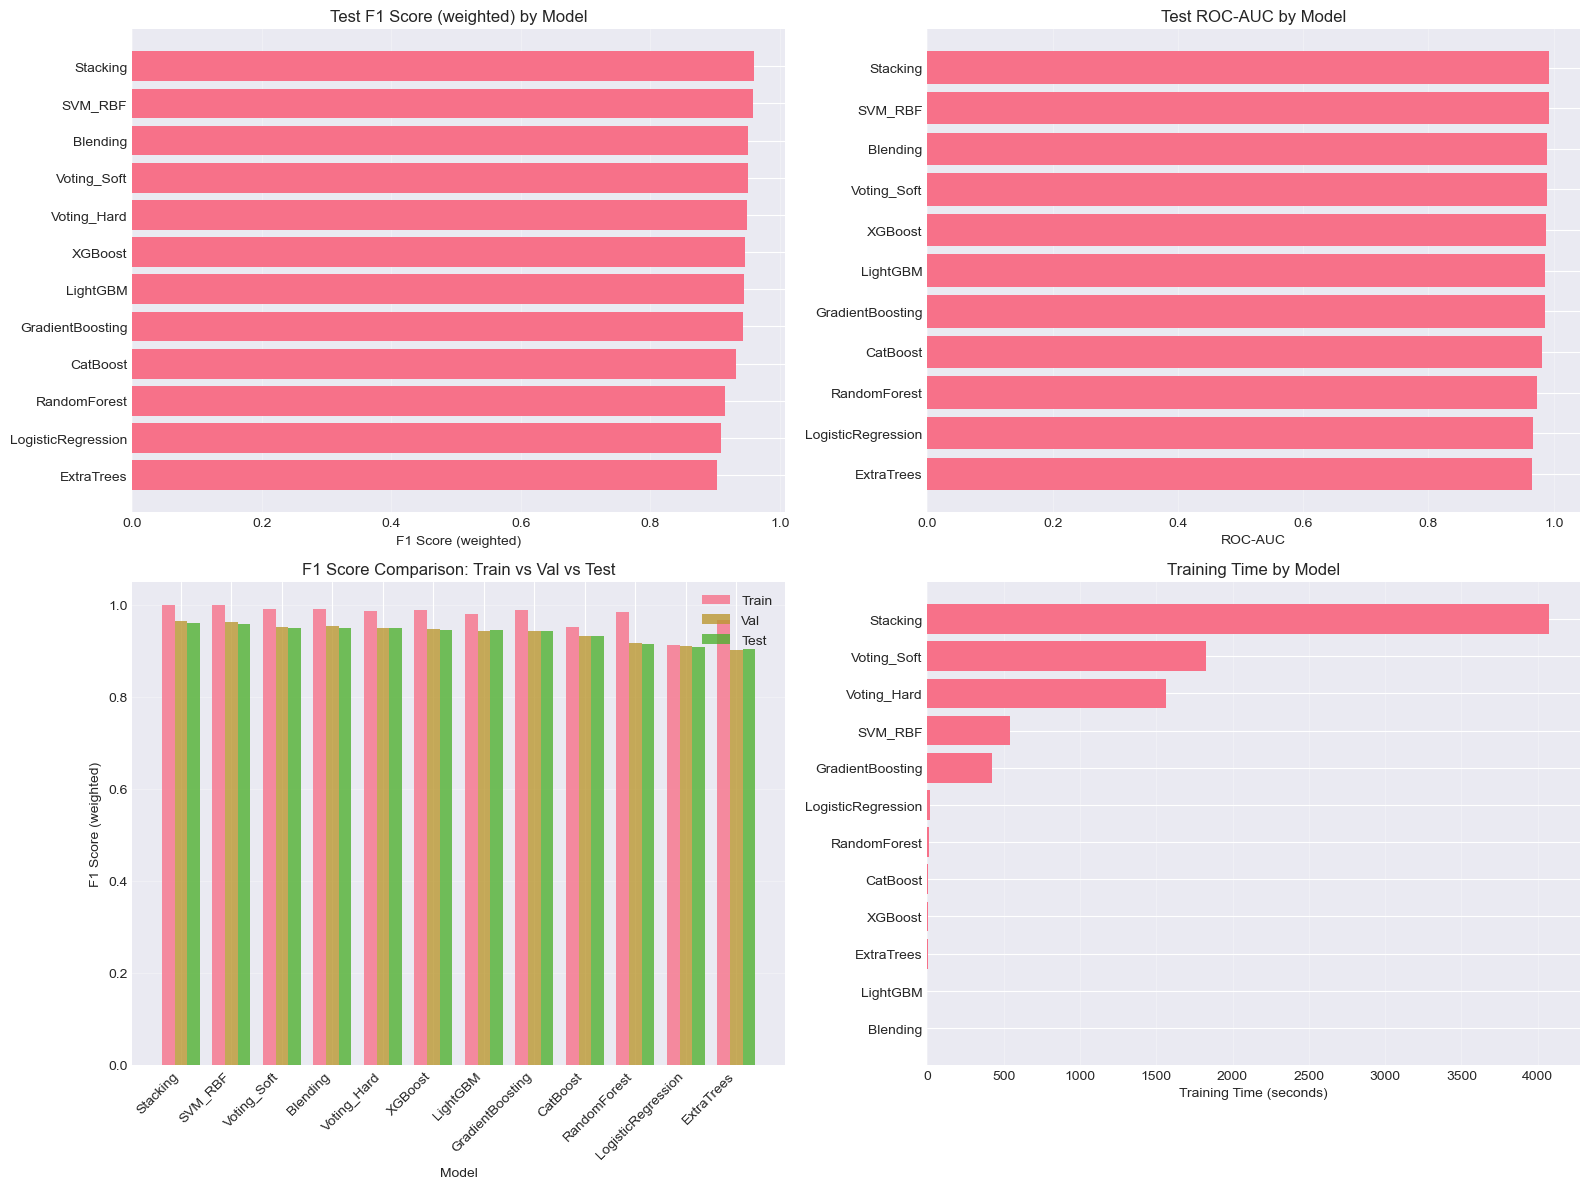

Visualization saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_results/model_comparison.png


In [19]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Bar plot of F1 scores
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test F1 (weighted)
ax1 = axes[0, 0]
results_df_sorted = results_df.sort_values('test_f1_weighted', ascending=True)
ax1.barh(results_df_sorted['model_name'], results_df_sorted['test_f1_weighted'])
ax1.set_xlabel('F1 Score (weighted)')
ax1.set_title('Test F1 Score (weighted) by Model')
ax1.grid(axis='x', alpha=0.3)

# Test ROC-AUC
ax2 = axes[0, 1]
results_df_sorted_auc = results_df[results_df['test_roc_auc'].notna()].sort_values('test_roc_auc', ascending=True)
if len(results_df_sorted_auc) > 0:
    ax2.barh(results_df_sorted_auc['model_name'], results_df_sorted_auc['test_roc_auc'])
    ax2.set_xlabel('ROC-AUC')
    ax2.set_title('Test ROC-AUC by Model')
    ax2.grid(axis='x', alpha=0.3)

# Comparison: Train vs Val vs Test F1
ax3 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.25
ax3.bar(x - width, results_df['train_f1_weighted'], width, label='Train', alpha=0.8)
ax3.bar(x, results_df['val_f1_weighted'], width, label='Val', alpha=0.8)
ax3.bar(x + width, results_df['test_f1_weighted'], width, label='Test', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('F1 Score (weighted)')
ax3.set_title('F1 Score Comparison: Train vs Val vs Test')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Training time comparison
ax4 = axes[1, 1]
results_df_sorted_time = results_df.sort_values('train_time', ascending=True)
ax4.barh(results_df_sorted_time['model_name'], results_df_sorted_time['train_time'])
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title('Training Time by Model')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {RESULTS_DIR / 'model_comparison.png'}")


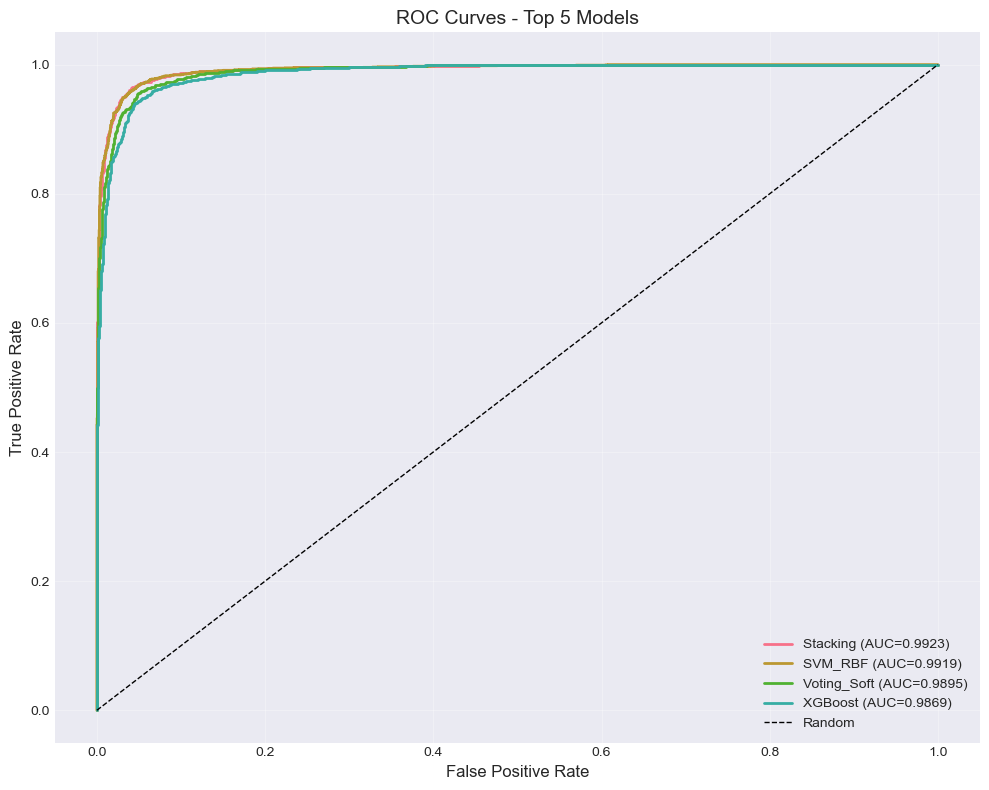

ROC curves saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_results/roc_curves.png


In [20]:
# 2. ROC Curves for top models
fig, ax = plt.subplots(figsize=(10, 8))

top_5_for_roc = results_df[results_df['test_roc_auc'].notna()].head(5)

for _, row in top_5_for_roc.iterrows():
    model_name = row['model_name']
    
    # Get model and predictions
    if model_name == 'XGBoost':
        model = xgb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'LightGBM':
        model = lgb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'CatBoost':
        model = cat_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'RandomForest':
        model = rf_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'ExtraTrees':
        model = et_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'LogisticRegression':
        model = lr_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'SVM_RBF':
        model = svm_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'GradientBoosting':
        model = gb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'Voting_Soft':
        model = voting_soft
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'Stacking':
        model = stacking_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        continue
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Top 5 Models', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC curves saved to {RESULTS_DIR / 'roc_curves.png'}")


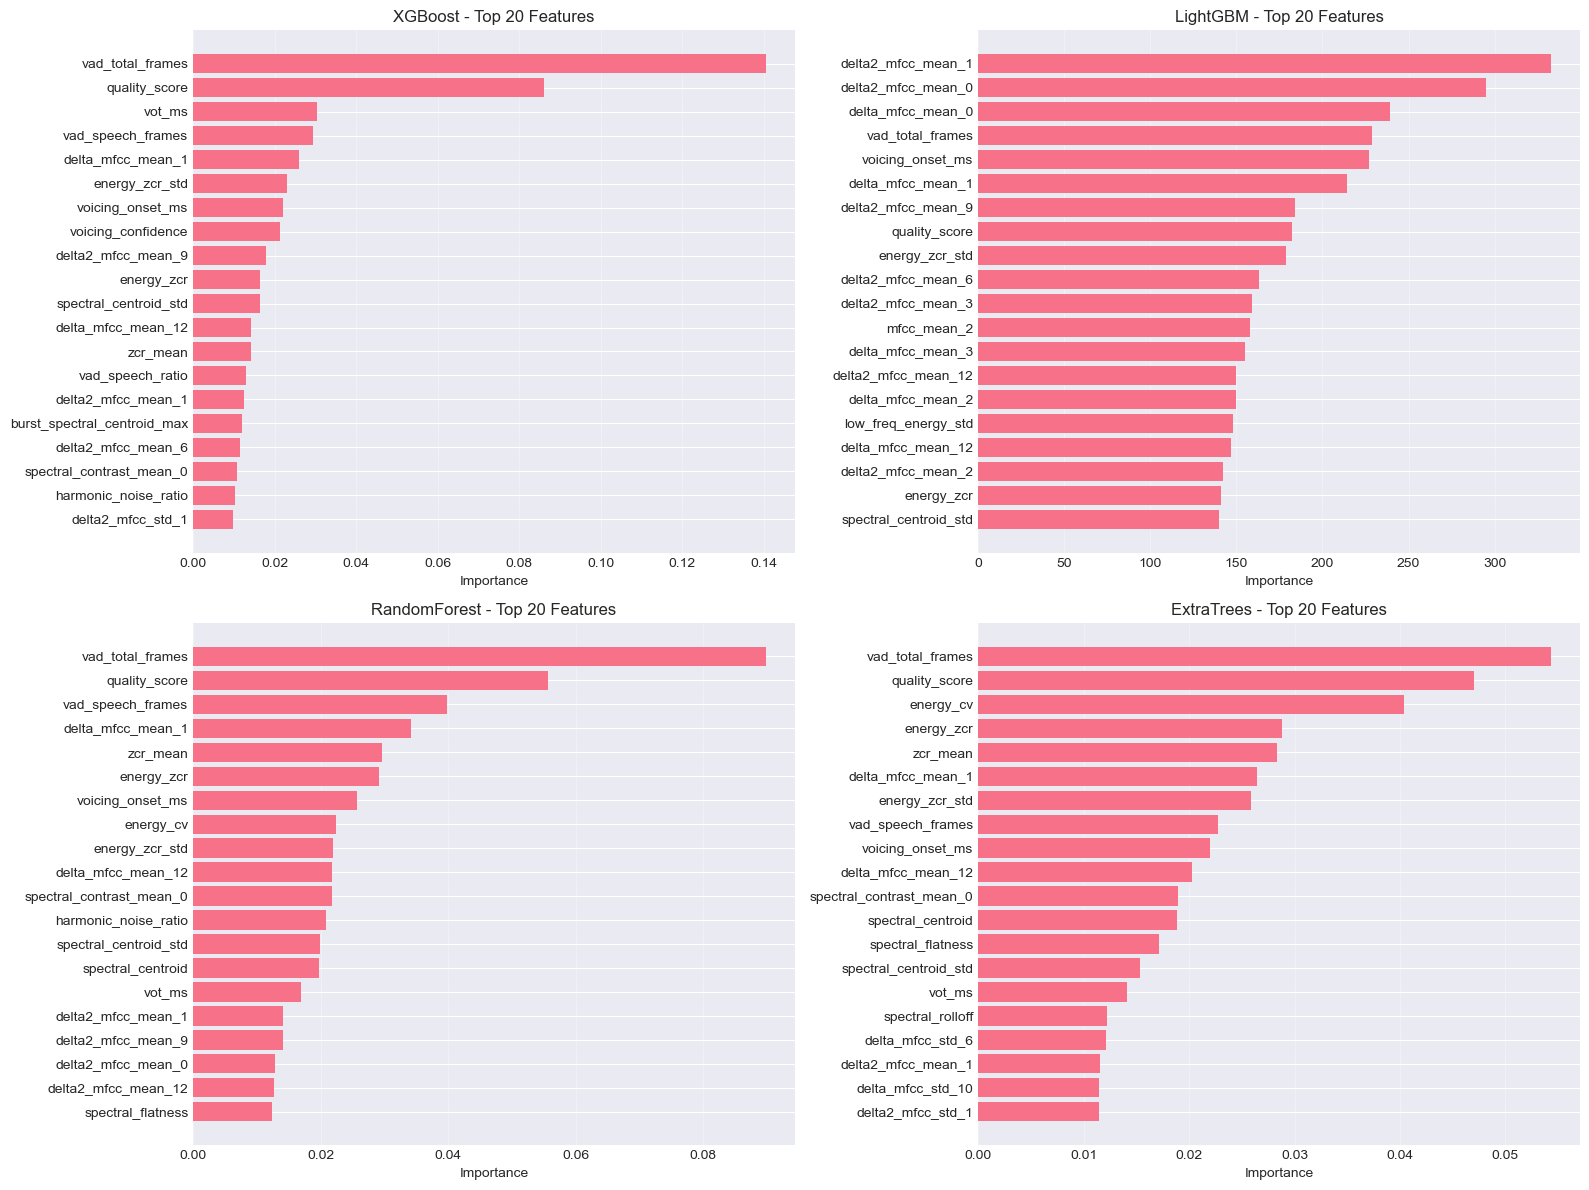

Feature importance plots saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_results/feature_importance.png


In [21]:
# 3. Feature Importance for tree-based models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

tree_models = [
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model),
    ('RandomForest', rf_model),
    ('ExtraTrees', et_model)
]

for idx, (name, model) in enumerate(tree_models):
    ax = axes[idx // 2, idx % 2]
    
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'get_feature_importance'):
            importances = model.get_feature_importance()
        else:
            continue
        
        # Get top 20 features
        top_indices = np.argsort(importances)[-20:][::-1]
        top_features = [feature_cols[i] for i in top_indices]
        top_importances = importances[top_indices]
        
        ax.barh(range(len(top_features)), top_importances)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Importance')
        ax.set_title(f'{name} - Top 20 Features')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f'Could not extract\nfeature importance', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{name}')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Feature importance plots saved to {RESULTS_DIR / 'feature_importance.png'}")


## 8. Saving Final Results


In [ ]:
# Save summary
summary = {
    'timestamp': datetime.now().isoformat(),
    'total_models': len(all_results),
    'best_model': results_df.iloc[0]['model_name'],
    'best_test_f1': float(results_df.iloc[0]['test_f1_weighted']),
    'best_test_roc_auc': float(results_df.iloc[0]['test_roc_auc']) if pd.notna(results_df.iloc[0]['test_roc_auc']) else None,
    'n_jobs': N_JOBS,
    'random_state': RANDOM_STATE,
    'n_features': len(feature_cols),
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'class_distribution': {
        'train': {'g': int(np.sum(y_train == 0)), 'k': int(np.sum(y_train == 1))},
        'val': {'g': int(np.sum(y_val == 0)), 'k': int(np.sum(y_val == 1))},
        'test': {'g': int(np.sum(y_test == 0)), 'k': int(np.sum(y_test == 1))}
    }
}

with open(RESULTS_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Summary saved to summary.json")
print(f"\nBest Model: {summary['best_model']}")
print(f"Best Test F1: {summary['best_test_f1']:.4f}")
roc_auc_str = f"{summary['best_test_roc_auc']:.4f}" if summary['best_test_roc_auc'] is not None else 'N/A'
print(f"Best Test ROC-AUC: {roc_auc_str}")

print(f"\nAll results and models saved to:")
print(f"  - Models: {OUTPUT_DIR}")
print(f"  - Results: {RESULTS_DIR}")


Summary saved to summary.json

Best Model: Stacking
Best Test F1: 0.9602
Best Test ROC-AUC: 0.9923

All results and models saved to:
  - Models: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_models
  - Results: /Volumes/SSanDisk/SpeechRec-German/artifacts/g-k_dl_models_with_context_v2/ml_results


: 